# Lab: Machine learning  
*Using the cardiovascular disease dataset.*

## EDA

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [106]:
df = pd.read_csv("../data/cardio.csv", sep=";")
df = df.drop(columns=["id"])

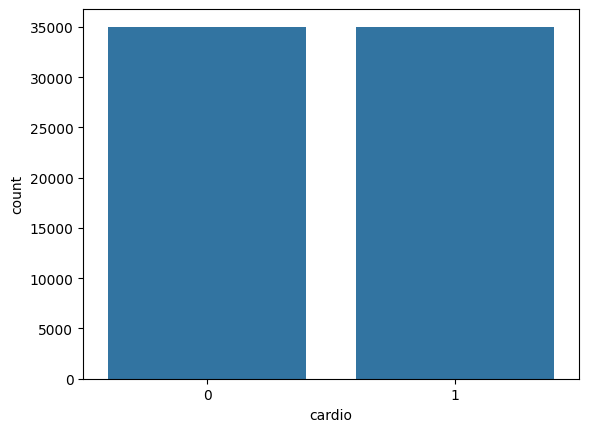

In [107]:
sns.countplot(data=df, x="cardio");

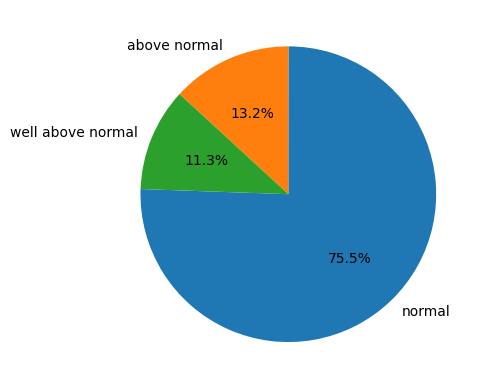

In [138]:
plt.pie(df["cholesterol"].value_counts(), labels=["normal", "above normal", "well above normal"], autopct="%1.1f%%", startangle=178);

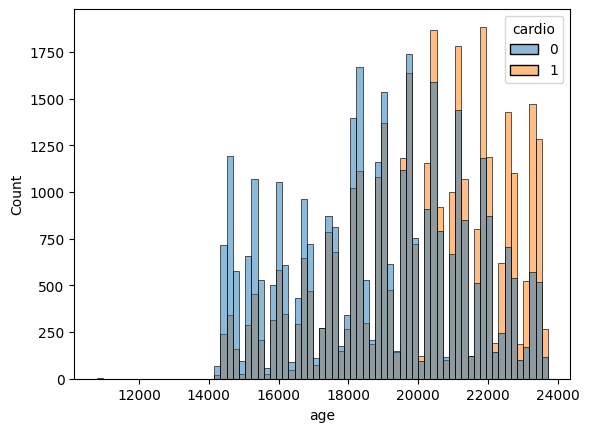

In [109]:
sns.histplot(data=df, x="age", hue="cardio");

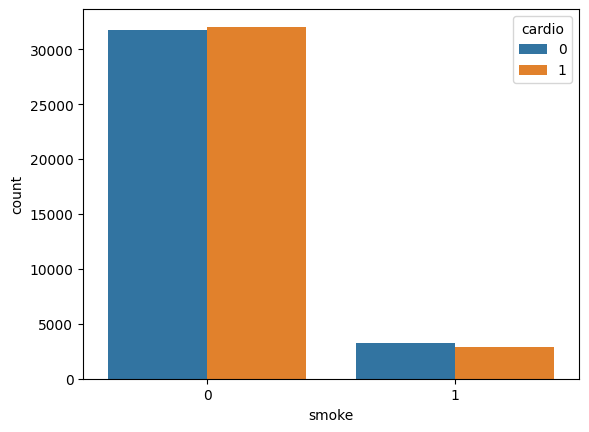

In [110]:
sns.countplot(data=df, x="smoke", hue="cardio");

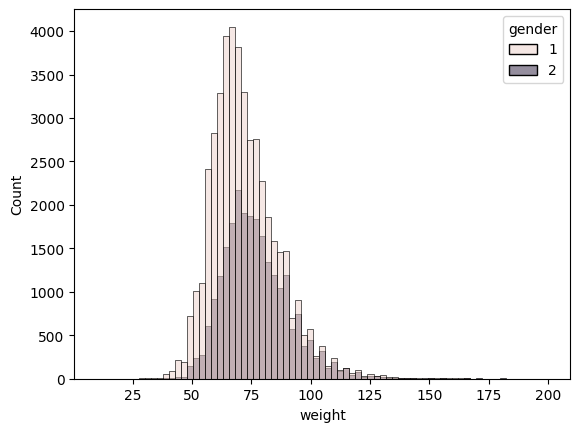

In [111]:
sns.histplot(data=df, x="weight", hue="gender", bins=75);

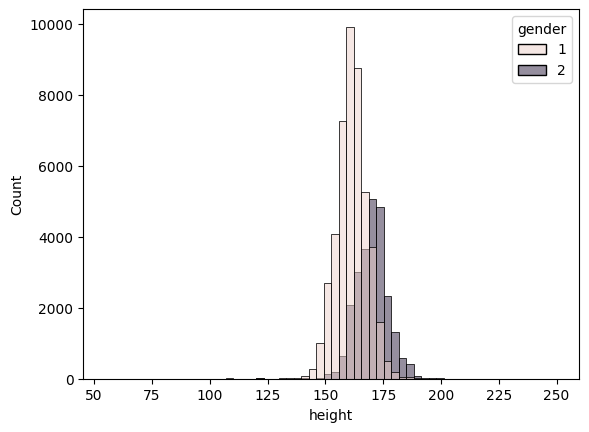

In [112]:
sns.histplot(data=df, x="height", hue="gender", bins=60);

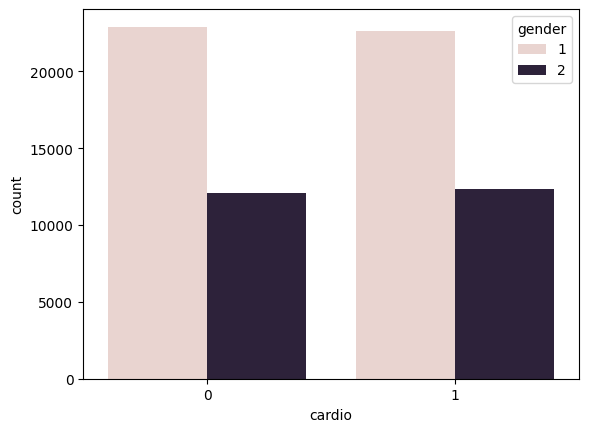

In [113]:
sns.countplot(data=df, x="cardio", hue="gender");

## Feature engineering
### BMI

In [114]:
df["bmi"] = df["weight"] / (df["height"] / 100) ** 2
df["bmi"] = df["bmi"].round(1)
df = df[["age", "gender", "height", "weight", "bmi", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"]]
df = df[(df["bmi"] > 16) & (df["bmi"] <= 40)]

Då labbinstruktionerna hänvisar till Wikipedia används de gränsvärden angivna där. Ursprunglig källa anges vara WHO och hänvisar till att människor med värden under 16 är "svårt tunna" medan de med värden över 40 lider av "fetma klass 3". 

In [115]:
bmi_labels = ["underweight", "normal", "overweight", "obese cl1", "obese cl2", "obese cl3"]
df["bmi_cat"] = pd.cut(df["bmi"], bins=[16, 18.5, 25, 30, 35, 40, float("inf")], labels=bmi_labels)
df = df[["age", "gender", "height", "weight", "bmi", "bmi_cat", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"]]

### blodtryck

In [116]:
df = df[(df["ap_hi"] >= 0) & (df["ap_hi"] <= 250) &
        (df["ap_lo"] >= 0) & (df["ap_lo"] <= 200)]
df.describe()

,age,gender,height,weight,bmi,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000,67145.000000
mean,19455.497029,1.354382,164.562693,73.163255,27.026501,126.053764,81.203336,1.357361,1.221118,0.088852,0.053571,0.804006,0.490074
std,2470.107419,0.478329,7.802323,12.785642,4.457275,17.534776,9.779434,0.673118,0.566974,0.284533,0.225170,0.396967,0.499905
min,10798.000000,1.000000,120.000000,28.000000,16.100000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17644.000000,1.000000,159.000000,65.000000,23.800000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19695.000000,1.000000,165.000000,71.000000,26.200000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21317.000000,2.000000,170.000000,81.000000,29.800000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,207.000000,135.000000,40.000000,240.000000,190.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


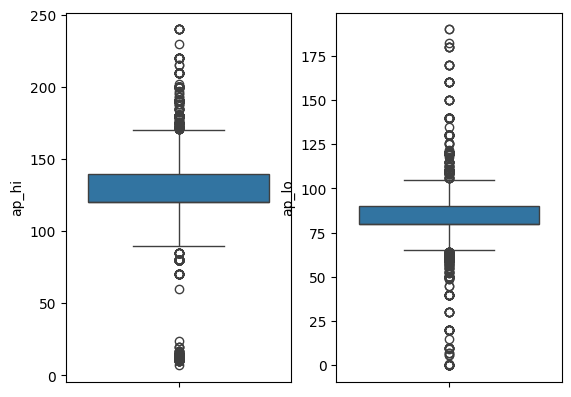

In [117]:
fig, ax = plt.subplots(1, 2)
sns.boxplot(data=df, y="ap_hi", ax=ax[0])
sns.boxplot(data=df, y="ap_lo", ax=ax[1])
plt.show()

Eftersom många outliers fortfarande är närvarande i datan används nedan IQR-metoden för att rensa fler outliers. 

In [118]:
def clear_outliers(df):    
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df = df[(df >= lower) & (df <= upper)]
    return df

df["ap_hi"] = clear_outliers(df["ap_hi"])
df["ap_lo"] = clear_outliers(df["ap_lo"])
df = df.dropna(how="any")

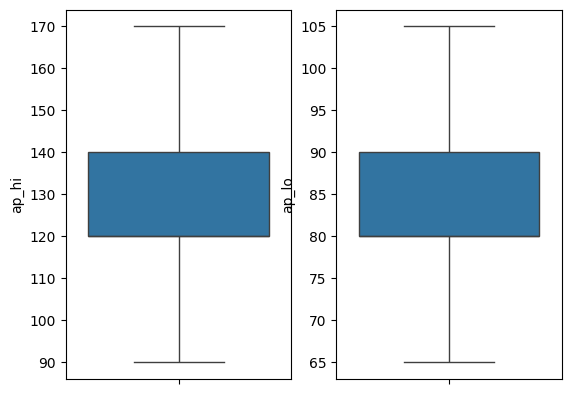

In [119]:
fig, ax = plt.subplots(1, 2)
sns.boxplot(data=df, y="ap_hi", ax=ax[0])
sns.boxplot(data=df, y="ap_lo", ax=ax[1])
plt.show()

In [120]:
bp_conditions = [
    (df["ap_hi"] <= 90) | (df["ap_lo"] <= 60), # with outlier I need | instead of & otherwise I get unknown values
    ((df["ap_hi"] >= 90) & (df["ap_hi"] < 120)) & (df["ap_lo"] < 80),
    ((df["ap_hi"] >= 120) & (df["ap_hi"] < 130)) & (df["ap_lo"] < 80),
    ((df["ap_hi"] >= 130) & (df["ap_hi"] < 140)) | ((df["ap_lo"] >= 80) & (df["ap_lo"] < 90)),
    ((df["ap_hi"] >= 140) & (df["ap_hi"] < 180)) | ((df["ap_lo"] >= 90) & (df["ap_lo"] < 120)),
    (df["ap_hi"] >= 180) | (df["ap_lo"] >= 120)
]
bp_labels = [
    "hypotension", 
    "normal", 
    "elevated", 
    "hypertension st1", 
    "hypertension st2", 
    "hypertension crisis"
]

df["ap_cat"] = np.select(bp_conditions, bp_labels, default="unknown")
df = df[["age", "gender", "height", "weight", "bmi", "bmi_cat", "ap_hi", "ap_lo", "ap_cat", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"]]
df

,age,gender,height,weight,bmi,bmi_cat,ap_hi,ap_lo,ap_cat,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,22.0,normal,110.0,80.0,hypertension st1,1,1,0,0,1,0
1,20228,1,156,85.0,34.9,obese cl1,140.0,90.0,hypertension st2,3,1,0,0,1,1
2,18857,1,165,64.0,23.5,normal,130.0,70.0,hypertension st1,3,1,0,0,0,1
3,17623,2,169,82.0,28.7,overweight,150.0,100.0,hypertension st2,1,1,0,0,1,1
5,21914,1,151,67.0,29.4,overweight,120.0,80.0,hypertension st1,2,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69993,19699,1,172,70.0,23.7,normal,130.0,90.0,hypertension st1,1,1,0,0,1,1
69994,21074,1,165,80.0,29.4,overweight,150.0,80.0,hypertension st1,1,1,0,0,1,1
69995,19240,2,168,76.0,26.9,overweight,120.0,80.0,hypertension st1,1,1,1,0,1,0
69998,22431,1,163,72.0,27.1,overweight,135.0,80.0,hypertension st1,1,2,0,0,0,1


In [121]:
df["ap_cat"].value_counts()

ap_cat
hypertension st1    38716
hypertension st2    14235
normal               7123
elevated             2595
hypotension           161
Name: count, dtype: int64

Då labbinstruktionerna hänvisar till Healthline används de gränsvärden angivna där. Det framgår även en källhänvisning till brittiska NHS som anger gränsvärden även för lågt blodtryck vilket implementerats här likaså. 

## Visualiseringar
### Andel sjukdomar

In [122]:
chol_gluc_labels = ["normal", "above normal", "well above normal"]
binary_labels = ["no", "yes"]

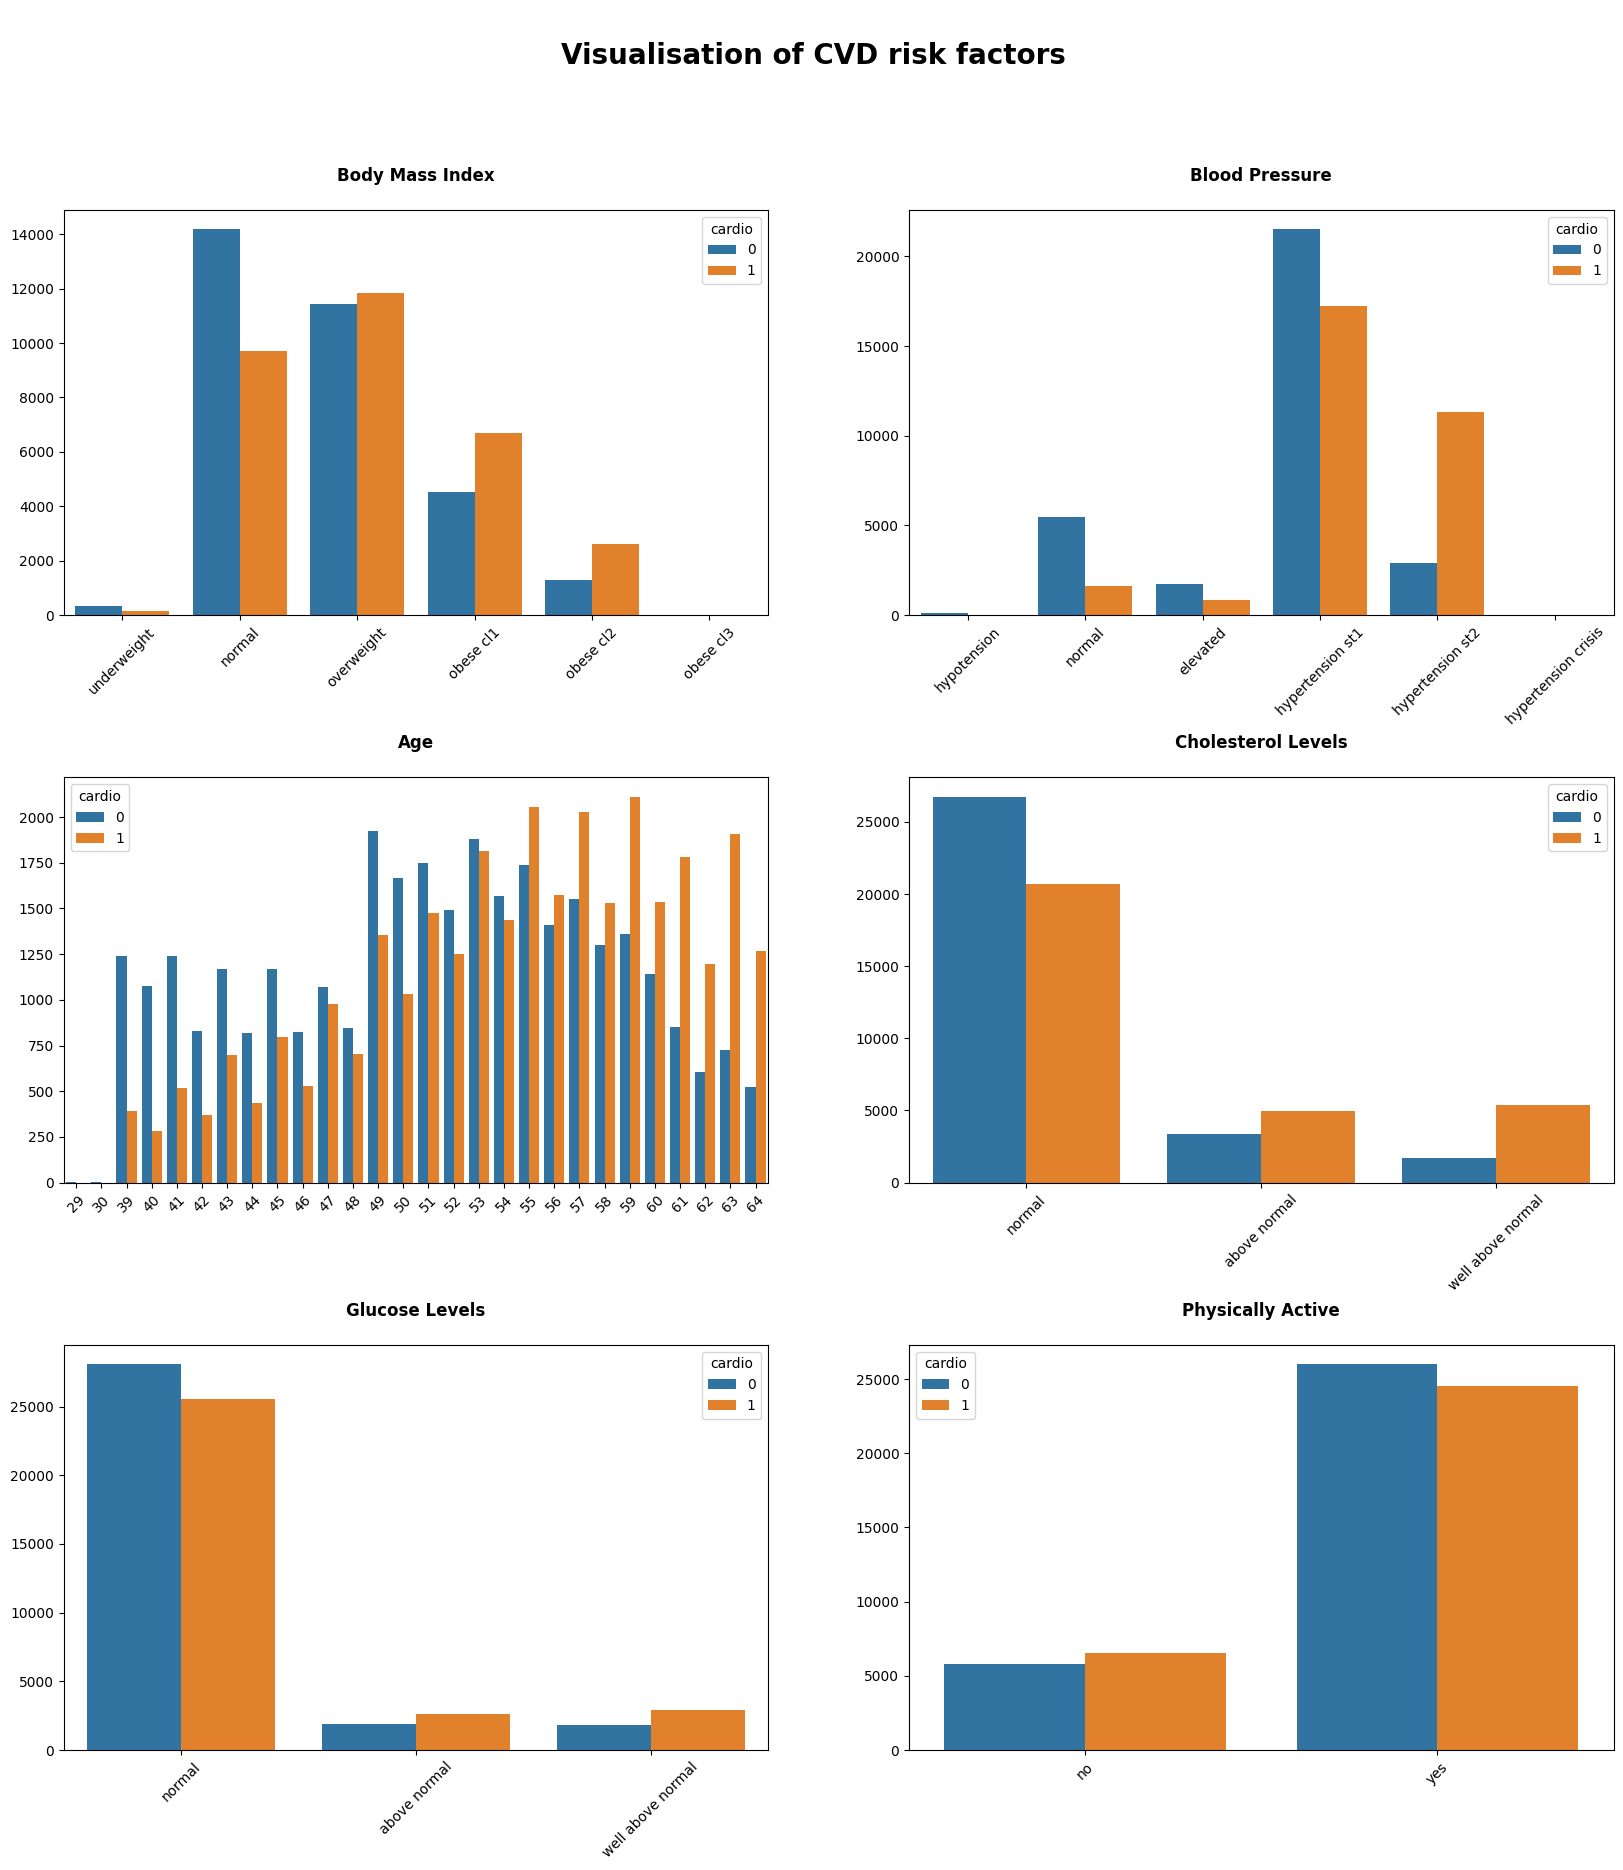

In [ ]:
# TODO: barplots instead? 

fig, ax = plt.subplots(3, 2, figsize=(20, 20))

sns.countplot(data=df, x="bmi_cat", order=bmi_labels, hue="cardio", ax=ax[0, 0])
ax[0, 0].tick_params(axis="x", rotation=45)
ax[0, 0].set_title("Body Mass Index\n", fontweight="bold")
ax[0, 0].set_xlabel("")
ax[0, 0].set_ylabel("")

sns.countplot(data=df, x="ap_cat", order=bp_labels, hue="cardio", ax=ax[0, 1])
ax[0, 1].tick_params(axis="x", rotation=45)
ax[0, 1].set_title("Blood Pressure\n", fontweight="bold")
ax[0, 1].set_xlabel("")
ax[0, 1].set_ylabel("")

sns.countplot(data=df, x=(df["age"] // 365.25).astype(int), hue="cardio", ax=ax[1, 0])
ax[1, 0].tick_params(axis="x", rotation=45)
ax[1, 0].set_title("Age\n", fontweight="bold")
ax[1, 0].set_xlabel("")
ax[1, 0].set_ylabel("")

sns.countplot(data=df, x="cholesterol", hue="cardio", ax=ax[1, 1])
ax[1, 1].tick_params(axis="x", rotation=45)
ax[1, 1].set_xticks([0, 1, 2])
ax[1, 1].set_xticklabels(chol_gluc_labels)
ax[1, 1].set_title("Cholesterol Levels\n", fontweight="bold")
ax[1, 1].set_xlabel("")
ax[1, 1].set_ylabel("")

sns.countplot(data=df, x="gluc", hue="cardio", ax=ax[2, 0])
ax[2, 0].tick_params(axis="x", rotation=45)
ax[2, 0].set_xticks([0, 1, 2])
ax[2, 0].set_xticklabels(chol_gluc_labels)
ax[2, 0].set_title("Glucose Levels\n", fontweight="bold")
ax[2, 0].set_xlabel("")
ax[2, 0].set_ylabel("")

sns.countplot(data=df, x="active", hue="cardio", ax=ax[2, 1])
ax[2, 1].tick_params(axis="x", rotation=45)
ax[2, 1].set_xticks([0, 1])
ax[2, 1].set_xticklabels(binary_labels)
ax[2, 1].set_title("Physically Active\n", fontweight="bold")
ax[2, 1].set_xlabel("")
ax[2, 1].set_ylabel("")

# fig.delaxes(ax[2, 1])  # Remove the empty subplot

fig.suptitle("\nVisualisation of CVD risk factors", fontweight="bold", fontsize=20)
plt.subplots_adjust(hspace=0.4)
plt.show()

### Korrelation

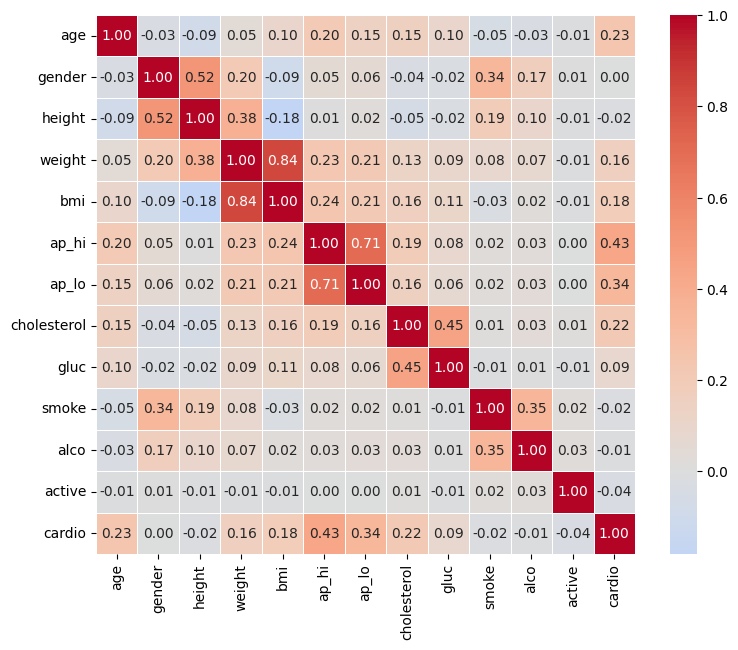

In [ ]:
# TODO: change all values to numeric
numerical_columns = df.describe().columns.to_list()
corr = df[numerical_columns].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True, linewidths=0.5)
plt.show()

BMI och vikt samt systoliskt och diastoliskt blodtryck kan ignoreras pga deras uppenbara relationer. Detsamma skulle kunna sägas för glukos och kolesterol.  

Mer intressanta observationer för detta dataset är att rökning har en viss relation till alkoholkonsumption men även kön.  

För syftet med labben är den sista raden den enda viktiga, korrelationer med vår responsvariabel. Då BMI har en högre korrelation än de separata variablerna för höjd och vikt vore det intressant att veta hur vår nuvarande kategoriska variabel för blodtryck påverkas. Andra kolumner av värde är ålder och kolesterol. 

## Dataset

In [125]:
df_a = df.copy().drop(columns=["height", "weight", "bmi", "ap_hi", "ap_lo"])
df_b = df.copy().drop(columns=["height", "weight", "bmi_cat", "ap_cat"])

df_a = pd.get_dummies(df_a, columns=["gender", "bmi_cat", "ap_cat"])
df_b = pd.get_dummies(df_b, columns=["gender"])

## Modeller

Välj fem modeller:  
- Logistic Regression  
- Support Vector Machines  
- Stochastic Gradient Descent  
- K-Nearest Neighbour  
- Random Forests  

In [ ]:
def splits(df):

    X_train, X_temp, y_train, y_temp = train_test_split(
        df.drop("cardio", axis=1), 
        df["cardio"], 
        test_size=0.3, 
        random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, 
        y_temp, 
        test_size=0.5, 
        random_state=42
    )
    return X_train, X_val, X_test, y_train, y_val, y_test


X_train_a, X_val_a, X_test_a, y_train_a, y_val_a, y_test_a = splits(df_a)
X_train_b, X_val_b, X_test_b, y_train_b, y_val_b, y_test_b = splits(df_b)

In [ ]:
def standardiser(X_train, X_val, X_test):

    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_val_std = scaler.transform(X_val)
    X_test_std = scaler.transform(X_test)
    
    return X_train_std, X_val_std, X_test_std


def normaliser(X_train, X_val, X_test):
    
    scaler = MinMaxScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_val_norm = scaler.transform(X_val)
    X_test_norm = scaler.transform(X_test)
    
    return X_train_norm, X_val_norm, X_test_norm


X_train_a_std, X_val_a_std, X_test_a_std = standardiser(X_train_a, X_val_a, X_test_a)
X_train_b_std, X_val_b_std, X_test_b_std = standardiser(X_train_b, X_val_b, X_test_b)
X_train_a_norm, X_val_a_norm, X_test_a_norm = normaliser(X_train_a, X_val_a, X_test_a)
X_train_b_norm, X_val_b_norm, X_test_b_norm = normaliser(X_train_b, X_val_b, X_test_b)

### Martins tips: spara resultat från modeller i CSV-filer så 